In [3]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
#Read datasets
#Download the data from http://www.saedsayad.com/datasets/CreditData.zip
train <- read.csv("Credit_train.csv")
test <- read.csv("Credit_test.csv")

In [5]:
#Show  
head(train)
head(test)

,BUSAGE,BUSTYPE,MAXLINEUTIL,DAYSDELQ,TOTACBAL,DEFAULT
,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,183,B,0,0,0.24,N
2,271,E,0,0,1.37,N
3,51,A,0,0,1.52,N
4,208,A,0,0,1.64,N
5,148,A,0,0,1.78,N
6,82,D,0,0,1.88,N


,BUSAGE,BUSTYPE,MAXLINEUTIL,DAYSDELQ,TOTACBAL,DEFAULT
,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,354,A,3.0425,0,152125.6,N
2,99,A,0.0000,0,151060.9,N
3,100,A,2.4507,0,122538.6,N
4,85,C,1.1397,0,113975.4,N
5,82,A,1.1241,0,112415.7,N
6,62,A,0.0000,0,106760.2,Y


In [6]:
#-------
# ZeroR
#-------

#train
train.frq <- table(train$DEFAULT)
max.frq <- which.max(train.frq)
model.zeror <- names(max.frq)

#test
test.count <- length(test$DEFAULT)
test.error <- length(which(test$DEFAULT != model.zeror))
test.accuracy <- 1-(test.error/test.count)

In [7]:
test.accuracy

[1] 0.9308541


    Attribute   Accuracy
1 * DAYSDELQ    91.67%  
2   BUSAGE      91.39%  
2   BUSTYPE     91.39%  
2   MAXLINEUTIL 91.39%  
2   TOTACBAL    91.39%  
---
Chosen attribute due to accuracy
and ties method (if applicable): '*'


Call:
OneR.formula(formula = DEFAULT ~ ., data = train.bin, verbose = TRUE)

Rules:
If DAYSDELQ = (-0.548,3.77] then DEFAULT = N
If DAYSDELQ = (3.77,549]    then DEFAULT = Y

Accuracy:
17425 of 19009 instances classified correctly (91.67%)

Contingency table:
       DAYSDELQ
DEFAULT (-0.548,3.77] (3.77,549]   Sum
    N         * 17333         40 17373
    Y            1544       * 92  1636
    Sum         18877        132 19009
---
Maximum in each column: '*'

Pearson's Chi-squared test:
X-squared = 622.88, df = 1, p-value < 2.2e-16


Confusion matrix (absolute):
          Actual
Prediction    N    Y  Sum
       N   4286  391 4677
       Y     11   18   29
       Sum 4297  409 4706

Confusion matrix (relative):
          Actual
Prediction    N    Y  Sum
       N 

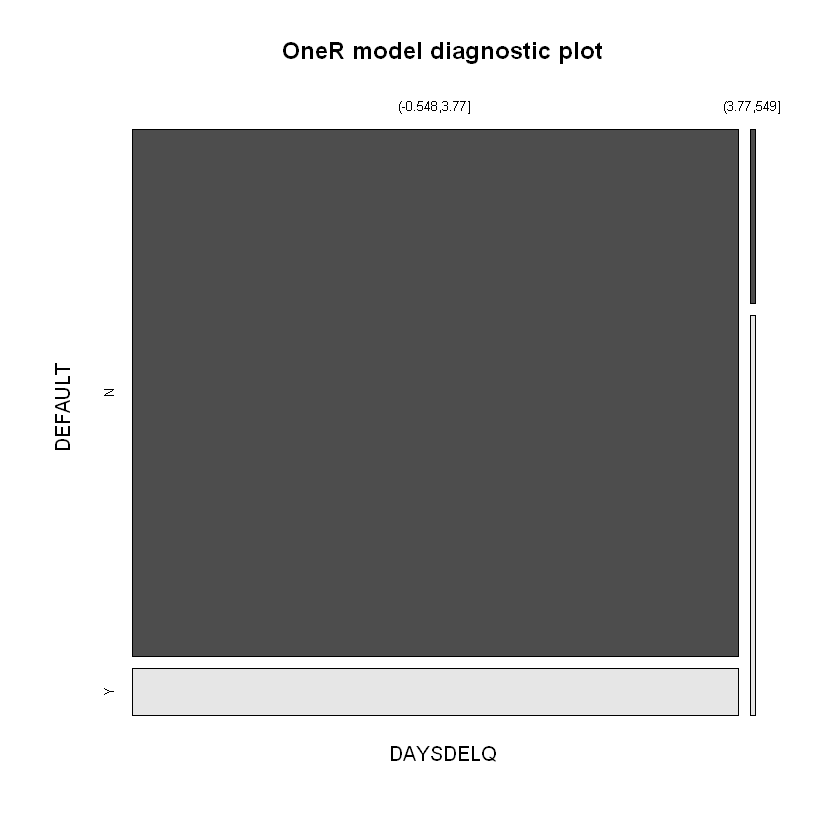

In [12]:
#------
# OneR
#------
library(OneR)
#remove all records with missing values
train <- na.omit(train)
test <- na.omit(test)

#binning the numerical variable
train.bin <- optbin(train)

#train
model.OneR <- OneR(DEFAULT~., data = train.bin, verbose = TRUE)
summary(model.OneR)
plot(model.OneR)

#test
pc <-NULL
pc <- predict(model.OneR, test, type = "class")
eval_model(pc,test)

In [13]:
#----------
# Bayesian
#----------
library(caret)
library(e1071)
library(AUC)

#train
model.Bayes <- naiveBayes(DEFAULT~., data = train)
model.Bayes

#test
pc <-NULL
pc <- predict(model.Bayes, test, type = "class")
summary(pc)
xtab <- table(pc, test$DEFAULT)
caret::confusionMatrix(xtab, positive = "Y")

#lift chart
pb <-NULL
pb <- predict(model.Bayes, test, type = "raw")
pb <- as.data.frame(pb)
pred.Bayes <- data.frame(test$DEFAULT,pb$Y)
colnames(pred.Bayes) <- c("target","score")
lift.Bayes <- lift(target ~ score, data = pred.Bayes, cuts=10, class="Y")
xyplot(lift.Bayes, main="Bayesian Classifier - Lift Chart", type=c("l","g"), lwd=2
       , scales=list(x=list(alternating=FALSE,tick.number = 10)
                     ,y=list(alternating=FALSE,tick.number = 10)))


#roc chart
labels <- as.factor(ifelse(pred.Bayes$target=="Y", 1, 0))
predictions <- pred.Bayes$score
auc(roc(predictions, labels), min = 0, max = 1)
plot(roc(predictions, labels), min=0, max=1, type="l", main="Bayesian Classifier - ROC Chart")


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
        N         Y 
0.9139355 0.0860645 

Conditional probabilities:
   BUSAGE
Y        [,1]      [,2]
  N 116.88465 105.44440
  Y  85.82885  84.05731

   BUSTYPE
Y              A            B            C            D            E
  N 0.6068612214 0.2442295516 0.0622805503 0.0828296782 0.0009785299
  Y 0.6075794621 0.2652811736 0.0470660147 0.0757946210 0.0006112469
   BUSTYPE
Y              F
  N 0.0028204685
  Y 0.0036674817

   MAXLINEUTIL
Y        [,1]      [,2]
  N 0.4498486 0.4116061
  Y 0.7775695 0.5188270

   DAYSDELQ
Y         [,1]      [,2]
  N 0.08311748  2.045589
  Y 3.76711491 23.109555

   TOTACBAL
Y       [,1]     [,2]
  N 22791.31 22537.03
  Y 27707.46 23662.82


integer(0)

ERROR: Error in table(pc, test$DEFAULT): all arguments must have the same length


ERROR: Error in lift.formula(target ~ score, data = pred.Dtree, cuts = 10, class = "Y"): the left-hand side of the formula must be a factor of classes


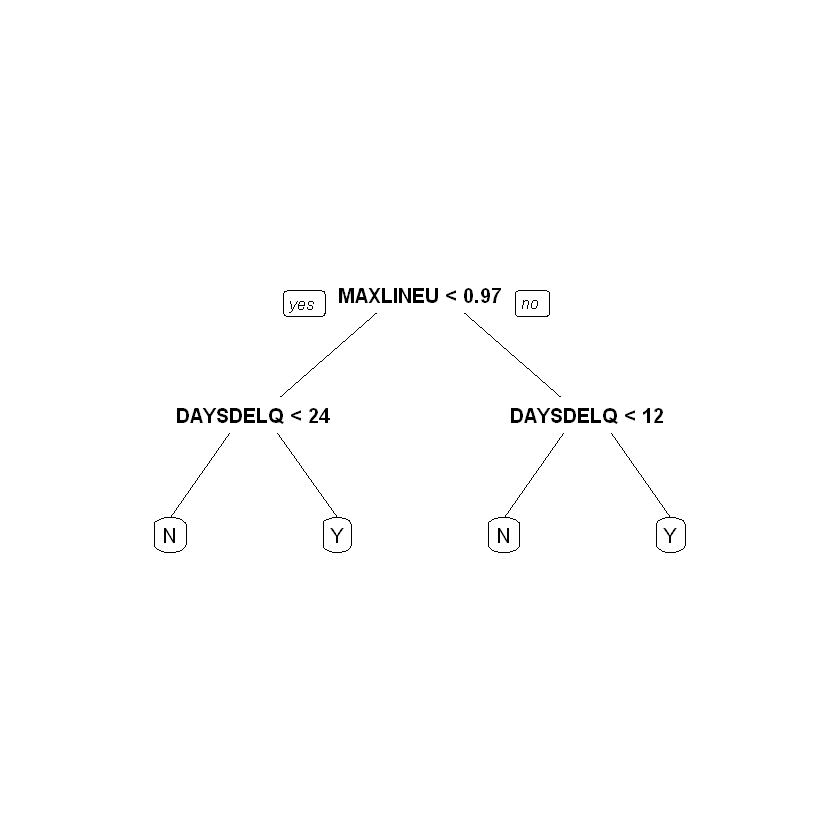

In [14]:
#---------------
# Decision tree
#---------------
library(caret)
library(rpart)
library(rpart.plot)	
library(AUC)

#train
model.Dtree <- rpart(DEFAULT~., data = train, method="class")
prp(model.Dtree)

#lift chart
pb <- NULL
pb <- predict(model.Dtree, test)
pb <- as.data.frame(pb)
pred.Dtree <- data.frame(test$DEFAULT, pb$Y)
colnames(pred.Dtree) <- c("target","score")
lift.Dtree <- lift(target ~ score, data = pred.Dtree, cuts=10, class="Y")
xyplot(lift.Dtree, main="Decision Tree - Lift Chart", type=c("l","g"), lwd=2
       , scales=list(x=list(alternating=FALSE,tick.number = 10)
                     ,y=list(alternating=FALSE,tick.number = 10)))

#confusion matrix
pc <- NULL
pc <- ifelse(pb$N > pb$Y, "N", "Y")
summary(as.data.frame(pc))
xtab <- table(pc, test$DEFAULT)
caret::confusionMatrix(xtab, positive = "Y")

#roc chart
labels <- as.factor(ifelse(pred.Dtree$target=="Y", 1, 0))
predictions <- pred.Dtree$score
auc(roc(predictions, labels), min = 0, max = 1)
plot(roc(predictions, labels), min=0, max=1, type="l", main="Decision Tree - ROC Chart")